# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

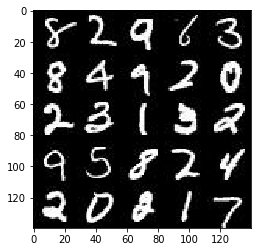

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

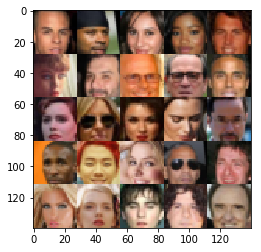

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_images') 
    input_z = tf.placeholder(tf.float32, [None, 100])
    
    learning_rate = tf.placeholder(tf.int32, None, name="learning_rate")
    
    return input_images, input_z, learning_rate

    # sources: https://github.com/udacity/deep-learning/blob/master/gan_mnist/Intro_to_GANs_Solution.ipynb



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2 # Leak Factor
    
    with tf.variable_scope('discriminator', reuse=reuse):        
        conv1 = tf.layers.conv2d(images, 32, 7, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)

        conv2 = tf.layers.conv2d(lrelu1, 64, 7, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)

        drop = tf.layers.dropout(lrelu2, rate=0.2)

        conv3 = tf.layers.conv2d(drop, 256, 7, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)

        features = tf.reduce_mean(lrelu3, (1, 2))        
        logits = tf.layers.dense(features, 1)

        out = tf.sigmoid(logits)

        return out, logits
        
        # sources: https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
        # https://discussions.udacity.com/t/discriminator-dimensions/246784 (to solve dimension issues)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = False
    alpha = 0.2 # Leak Factor
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)

        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
        return out

        # sources: https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
        # https://discussions.udacity.com/t/face-generation-generator-dimensions/400276/4
        # https://discussions.udacity.com/t/scope-error-in-generator-network/246466/23

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real) * 0.9))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

    # sources: https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    # https://discussions.udacity.com/t/for-function-model-loss-test-results-are-returning-valueerror-logits-and-labels-must-have-the-same-shape-1-vs-28-28-4/338107/2
    # https://discussions.udacity.com/t/share-variable-error/279695/7

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

    # Used exact model_opt function found in the DCGAN project:
    # https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    show_every = 150
    
    input_real, input_z, learn_rate_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # B&W VS RGB
    if(data_image_mode == 'RGB'):
        out_channels_dim = 3
    else:
        out_channels_dim = 1
        
        
    d_loss, g_loss = model_loss(input_real, input_z, out_channels_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        saver = tf.train.Saver()
        steps = 0
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                #Normalize input
                batch_images = batch_images * 2
                #Generate random unifrom z vector
                batch_z = np.random.uniform(-1 , 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate_tensor: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate_tensor: learning_rate})
                
                #Print stats
                if steps % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, out_channels_dim, data_image_mode)
        saver.save(sess, './generator.ckpt')

    # sources: https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    # https://discussions.udacity.com/t/problem-with-train-function-valueerror-no-variables-to-save/262833
    # https://discussions.udacity.com/t/share-variable-error/279695
    # https://discussions.udacity.com/t/error-in-training-the-network/266481/8

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 1.0642
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.7791
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 0.8644


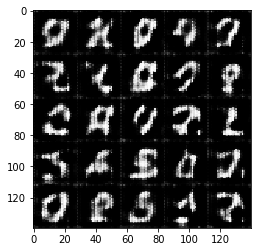

Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.7554
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 1.3103... Generator Loss: 0.8308


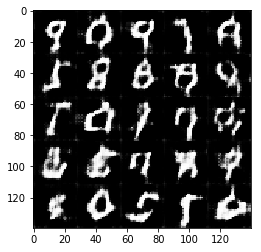

Epoch 1/2... Discriminator Loss: 1.2954... Generator Loss: 0.8396
Epoch 1/2... Discriminator Loss: 1.3135... Generator Loss: 0.8184
Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 0.7788


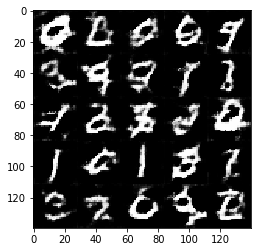

Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 0.8150
Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.7941


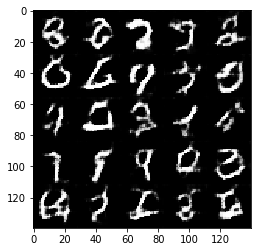

Epoch 1/2... Discriminator Loss: 1.3274... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.3392... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 1.2992... Generator Loss: 0.8058


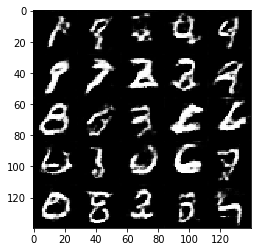

Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.7946
Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 0.8326
Epoch 1/2... Discriminator Loss: 1.3504... Generator Loss: 0.7950


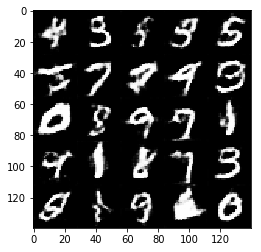

Epoch 1/2... Discriminator Loss: 1.3000... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 1.2937... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.3347... Generator Loss: 0.7523


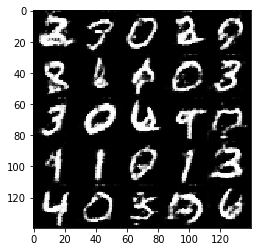

Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.7928
Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 0.8566
Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 0.8089


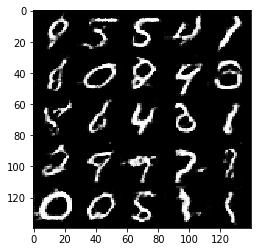

Epoch 1/2... Discriminator Loss: 1.3174... Generator Loss: 0.7899
Epoch 1/2... Discriminator Loss: 1.3272... Generator Loss: 0.7534
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 0.7962


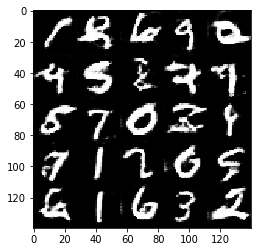

Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 0.8206
Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 1.3123... Generator Loss: 0.7908


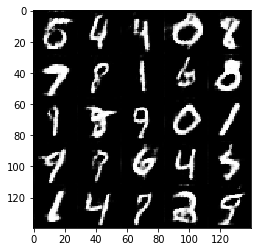

Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 0.8216
Epoch 1/2... Discriminator Loss: 1.2874... Generator Loss: 0.7910
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.7886


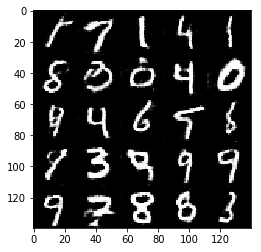

Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 0.8332
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 0.7648
Epoch 1/2... Discriminator Loss: 1.2838... Generator Loss: 0.7813


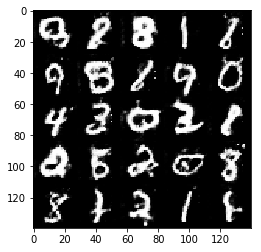

Epoch 1/2... Discriminator Loss: 1.2417... Generator Loss: 0.8162
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 0.8724
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.8160


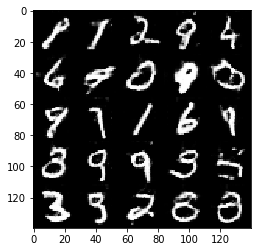

Epoch 2/2... Discriminator Loss: 1.2949... Generator Loss: 0.8350
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.7946
Epoch 2/2... Discriminator Loss: 1.3218... Generator Loss: 0.8045


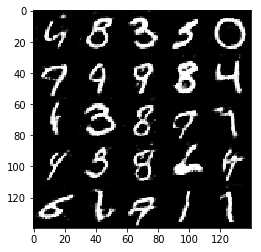

Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.7621
Epoch 2/2... Discriminator Loss: 1.2644... Generator Loss: 0.8120
Epoch 2/2... Discriminator Loss: 1.2439... Generator Loss: 0.8224


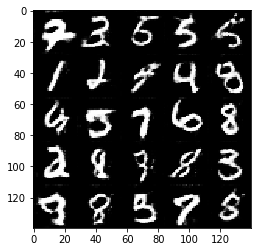

Epoch 2/2... Discriminator Loss: 1.3504... Generator Loss: 0.8164
Epoch 2/2... Discriminator Loss: 1.2821... Generator Loss: 0.8070
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.8208


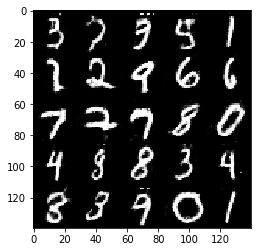

Epoch 2/2... Discriminator Loss: 1.2913... Generator Loss: 0.8165
Epoch 2/2... Discriminator Loss: 1.2676... Generator Loss: 0.7781
Epoch 2/2... Discriminator Loss: 1.2700... Generator Loss: 0.8464


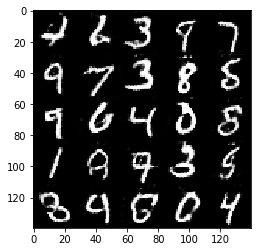

Epoch 2/2... Discriminator Loss: 1.2610... Generator Loss: 0.7761
Epoch 2/2... Discriminator Loss: 1.3220... Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 1.2679... Generator Loss: 0.8076


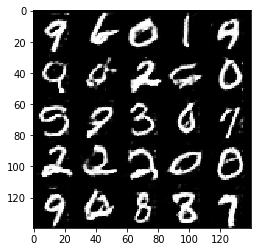

Epoch 2/2... Discriminator Loss: 1.2413... Generator Loss: 0.8103
Epoch 2/2... Discriminator Loss: 1.2562... Generator Loss: 0.8314
Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 0.7445


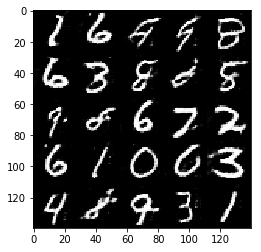

Epoch 2/2... Discriminator Loss: 1.2045... Generator Loss: 0.9057
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 0.9675
Epoch 2/2... Discriminator Loss: 1.3029... Generator Loss: 0.6873


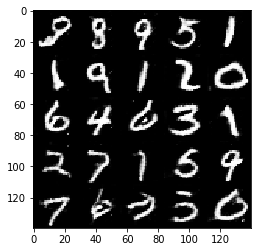

Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 0.8184
Epoch 2/2... Discriminator Loss: 1.2329... Generator Loss: 0.8560


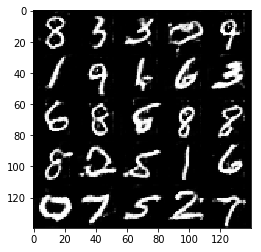

Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 1.1970... Generator Loss: 0.8442
Epoch 2/2... Discriminator Loss: 1.2954... Generator Loss: 0.7054


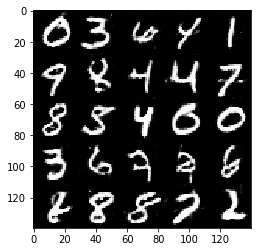

Epoch 2/2... Discriminator Loss: 1.2421... Generator Loss: 0.8100
Epoch 2/2... Discriminator Loss: 1.2744... Generator Loss: 0.7395
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.7754


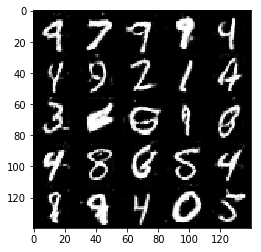

Epoch 2/2... Discriminator Loss: 1.1453... Generator Loss: 0.8714
Epoch 2/2... Discriminator Loss: 1.2677... Generator Loss: 0.8387
Epoch 2/2... Discriminator Loss: 1.3346... Generator Loss: 0.7169


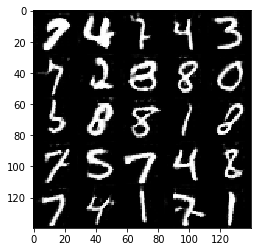

Epoch 2/2... Discriminator Loss: 1.2253... Generator Loss: 0.7580
Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 0.8852
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 0.7844


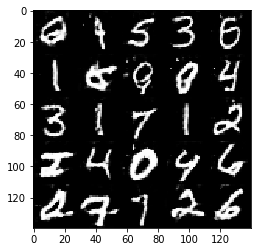

In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6227... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.8102


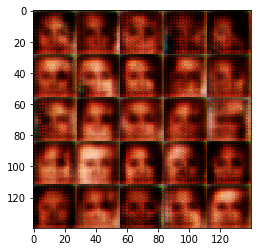

Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8086


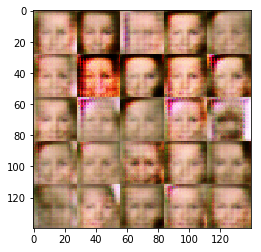

Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7910


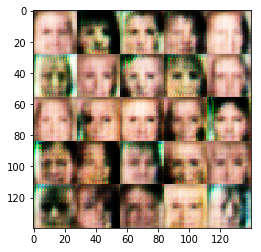

Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7778


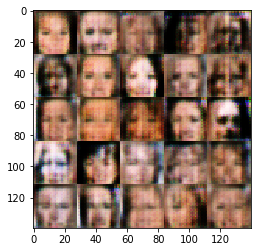

Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.8222


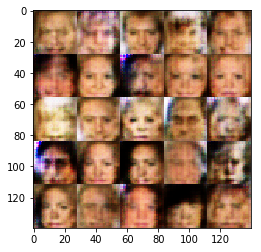

Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7895


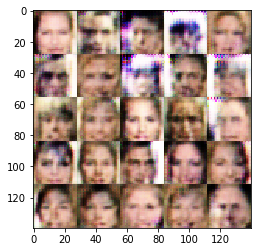

Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.8208


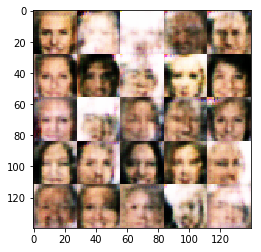

Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7705


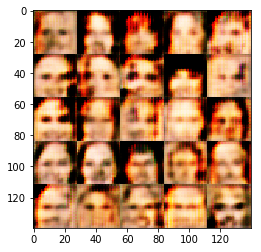

Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8109


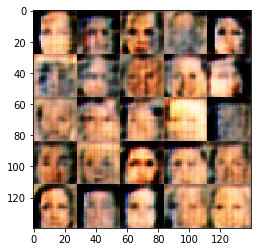

Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7859


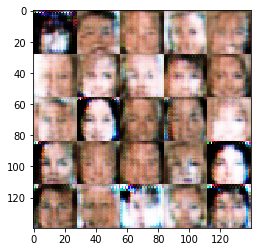

Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7947


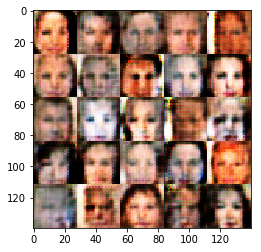

Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7871


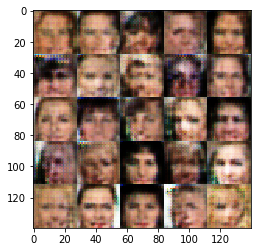

Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7952


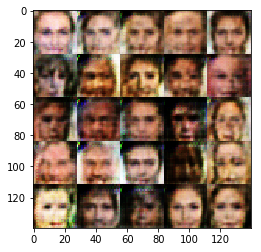

Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.7915


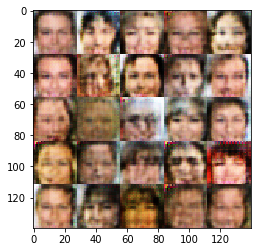

Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7724


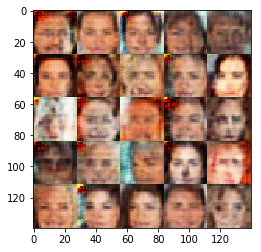

Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8039


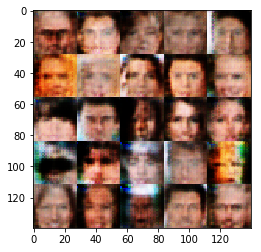

Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7475


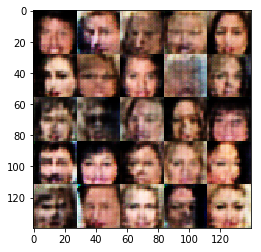

Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7395


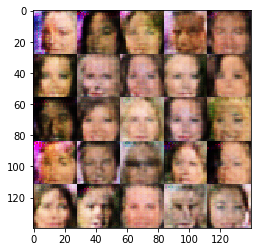

Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7621


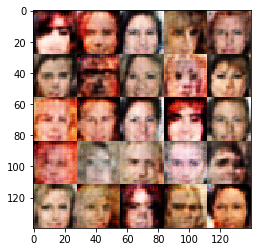

Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8009


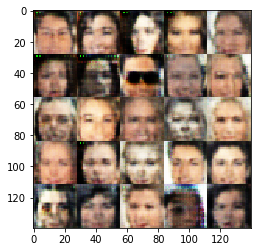

Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7960


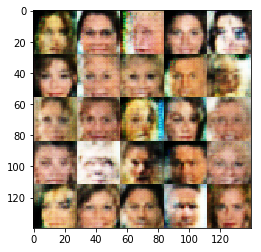

Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7645


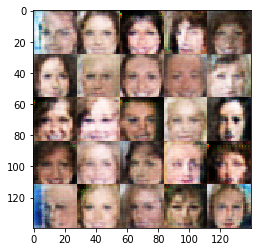

Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7904


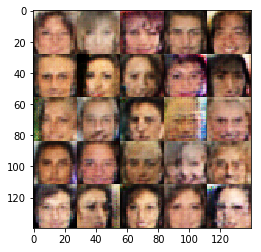

Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.7943


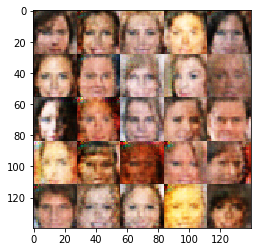

Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8039


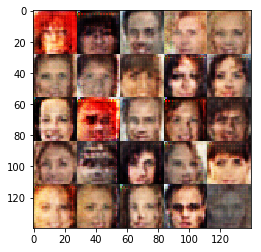

Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7880


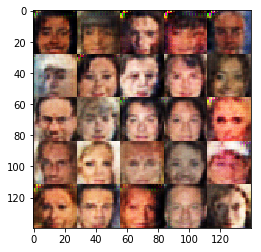

Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7656


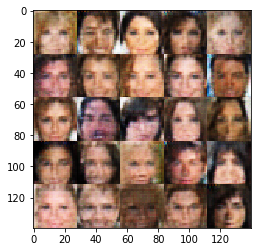

Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7824


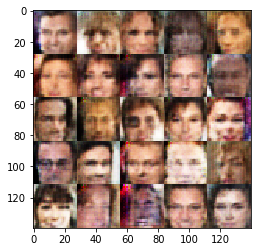

Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7871


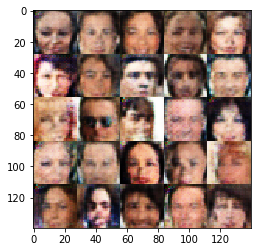

Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7995


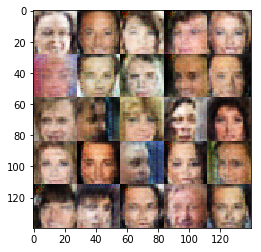

Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7983


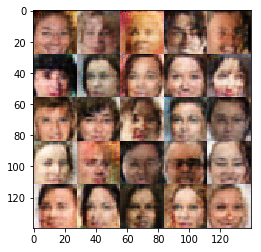

Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7761


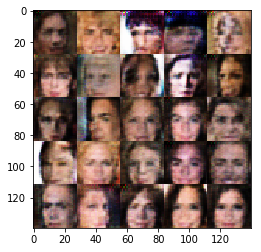

Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7561


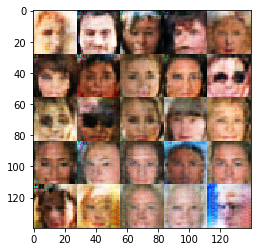

Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7754


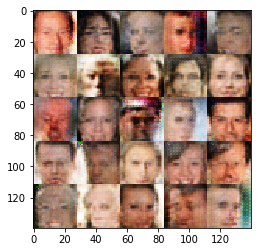

Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7894


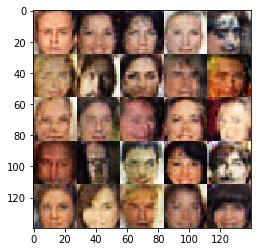

Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.7964


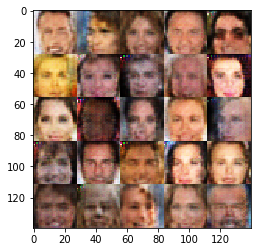

Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7860


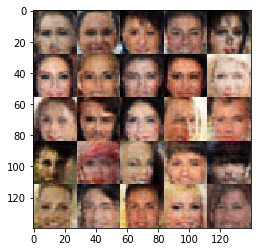

Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7891


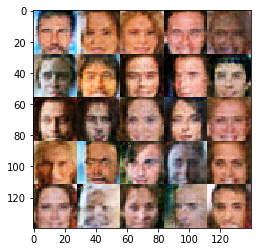

Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7639


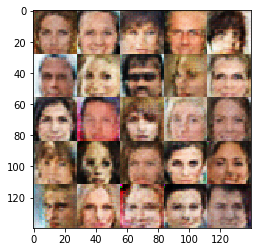

Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7989


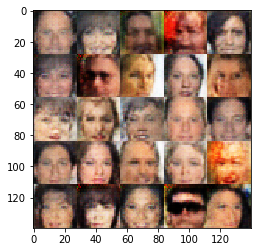

Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7897


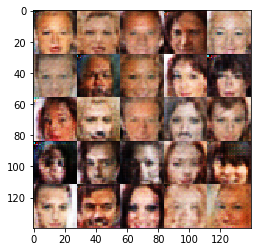

Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7810


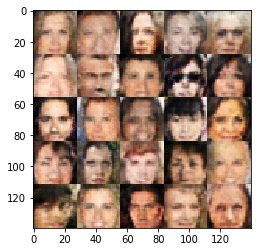

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.